In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Sun Jun 12 19:26:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   39C    P8    21W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 29%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_de = db.patent_de
    # db_us = db.patent_us
    # db_cn = db.patent_cn

    db_rm_cn_2012 = db.rm_patent_cn_2012
    db_rm_us_2012 = db.rm_patent_us_2012
    db_rm_de_2012 = db.rm_patent_de_2012

    
except errors.ConnectionFailure as err:
    print(err)

# 2012

## Company數量

In [6]:
data_assignee = db_rm_de_2012.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [7]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [8]:
data_assignee = db_rm_cn_2012.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [9]:
data_assignee = db_rm_us_2012.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [10]:
final_df = pd.concat([df_family_de,df_family_cn,df_family_us],axis=0)

In [11]:
# 取總數前15家公司
final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(50)

,company,count
32,Jiangsu IoT Research and Development Center,100
42,Nanjing IoT Sensor Technology Co Ltd,52
9,Cisco Technology Inc,33
8,China core Microelectronics Technology Chengdu...,25
40,NANJING AQUAPEL IOT CO Ltd,20
3,"BEIJING GOLDENET IOT TECHNOLOGY CO., LTD.",18
63,Xerox Corp,17
17,"Gaoxing Zhilian Technology Co., Ltd.",17
27,Institute of Microelectronics of CAS,13
31,Jiangsu CAS IGBT Technology Co Ltd,12


In [35]:
com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(19)
com_df = com_df.append({"company":"Samsung Electronics Co Ltd","count":4}, ignore_index=True)
com_df.reset_index(drop=True, inplace=True)

In [36]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))
com_df

,company,count,count_log
0,Jiangsu IoT Research and Development Center,100,4.605170
1,Nanjing IoT Sensor Technology Co Ltd,52,3.951244
2,Cisco Technology Inc,33,3.496508
3,China core Microelectronics Technology Chengdu...,25,3.218876
4,NANJING AQUAPEL IOT CO Ltd,20,2.995732
5,"BEIJING GOLDENET IOT TECHNOLOGY CO., LTD.",18,2.890372
6,Xerox Corp,17,2.833213
7,"Gaoxing Zhilian Technology Co., Ltd.",17,2.833213
8,Institute of Microelectronics of CAS,13,2.564949
9,Jiangsu CAS IGBT Technology Co Ltd,12,2.484907


In [37]:
com_ls = list(com_df.company)

## Data

In [38]:
ccontry = pd.read_csv("./final_data/rm_company_country_all_2012.csv")
ccpc = pd.read_csv("./final_data/rm_company_cpc_all_2012.csv")

In [39]:
ccontry[ccontry.company.isin(com_ls)].head()

,company,AP,AR,AU,BR,CA,CL,CN,CO,CR,...,RS,RU,SE,SG,SI,TN,TW,US,UY,ZA
24,"BEIJING GOLDENET IOT TECHNOLOGY CO., LTD.",0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55,Chengdu Qinchuan IoT Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
67,China Petroleum and Chemical Corp,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,China core Microelectronics Technology Chengdu...,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,Cisco Technology Inc,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0


## Similarity計算

### Country

- 換成機率  

In [40]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

### PBC
- 和Samsung Electronics Co Ltd比較

In [41]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc.head()

,AP,AR,AU,BR,CA,CL,CN,CO,CR,CU,...,RS,RU,SE,SG,SI,TN,TW,US,UY,ZA
company,,,,,,,,,,,,,,,,,,,,,
Jiangsu IoT Research and Development Center,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nanjing IoT Sensor Technology Co Ltd,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cisco Technology Inc,0.0,0.0,0.0,0.0,0.109091,0.0,0.018182,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0
"China core Microelectronics Technology Chengdu Co.,Ltd.",0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NANJING AQUAPEL IOT CO Ltd,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### CPC

In [43]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [44]:
# ccpc_pbc = ccpc2.loc[com_ls,:].copy()
ccpc_pbc = ccpc2[ccpc2.index.isin(com_ls)]
# ccpc_pbc

In [45]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

## Scatter Plot

In [46]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

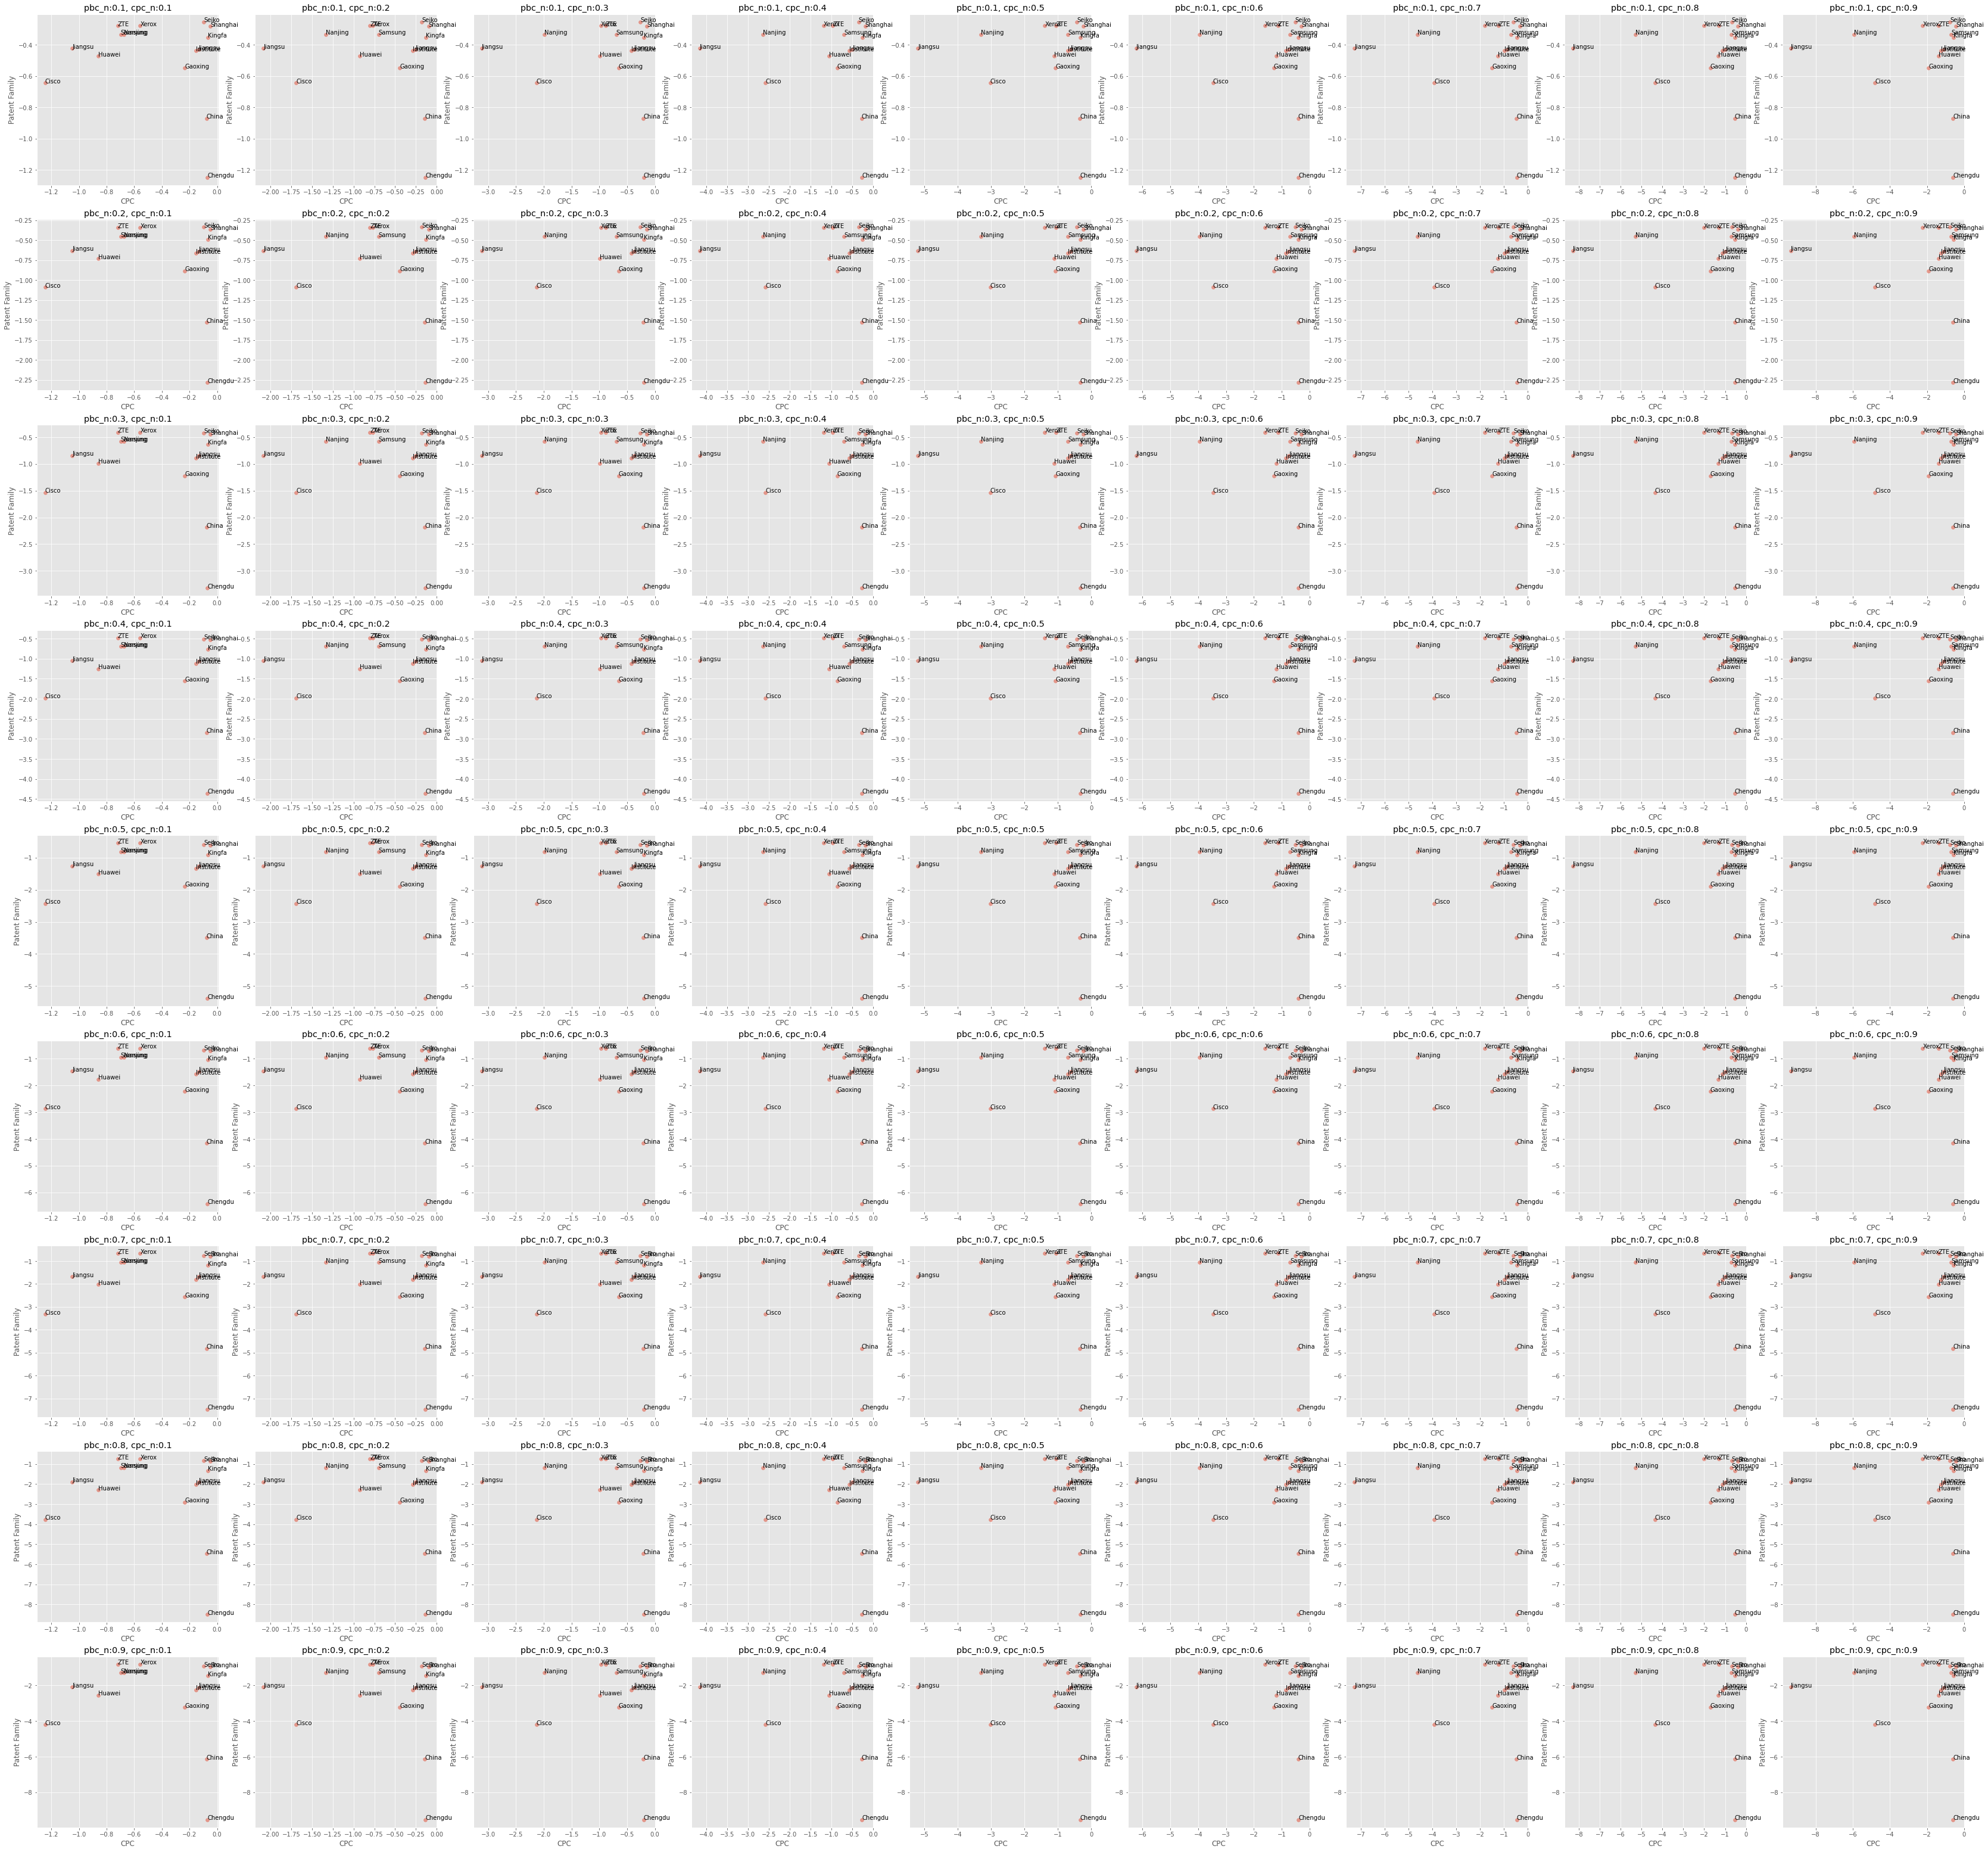

In [47]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        # c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2012_1.png'.format(pbc_n))

In [48]:
c_df

,cpc,country
company,,
Chengdu Qinchuan IoT Technology Co Ltd,0.596725,9.537167
China Petroleum and Chemical Corp,0.602300,6.133190
Cisco Technology Inc,4.806821,4.206598
"Gaoxing Zhilian Technology Co., Ltd.",1.908607,3.234641
Huawei Technologies Co Ltd,1.384718,2.543383
Institute of Microelectronics of CAS,1.262500,2.248145
Jiangsu CAS IGBT Technology Co Ltd,1.098449,2.104313
Jiangsu IoT Research and Development Center,9.337597,2.096338
Kingfa Science and Technology Co Ltd,0.591847,1.462426


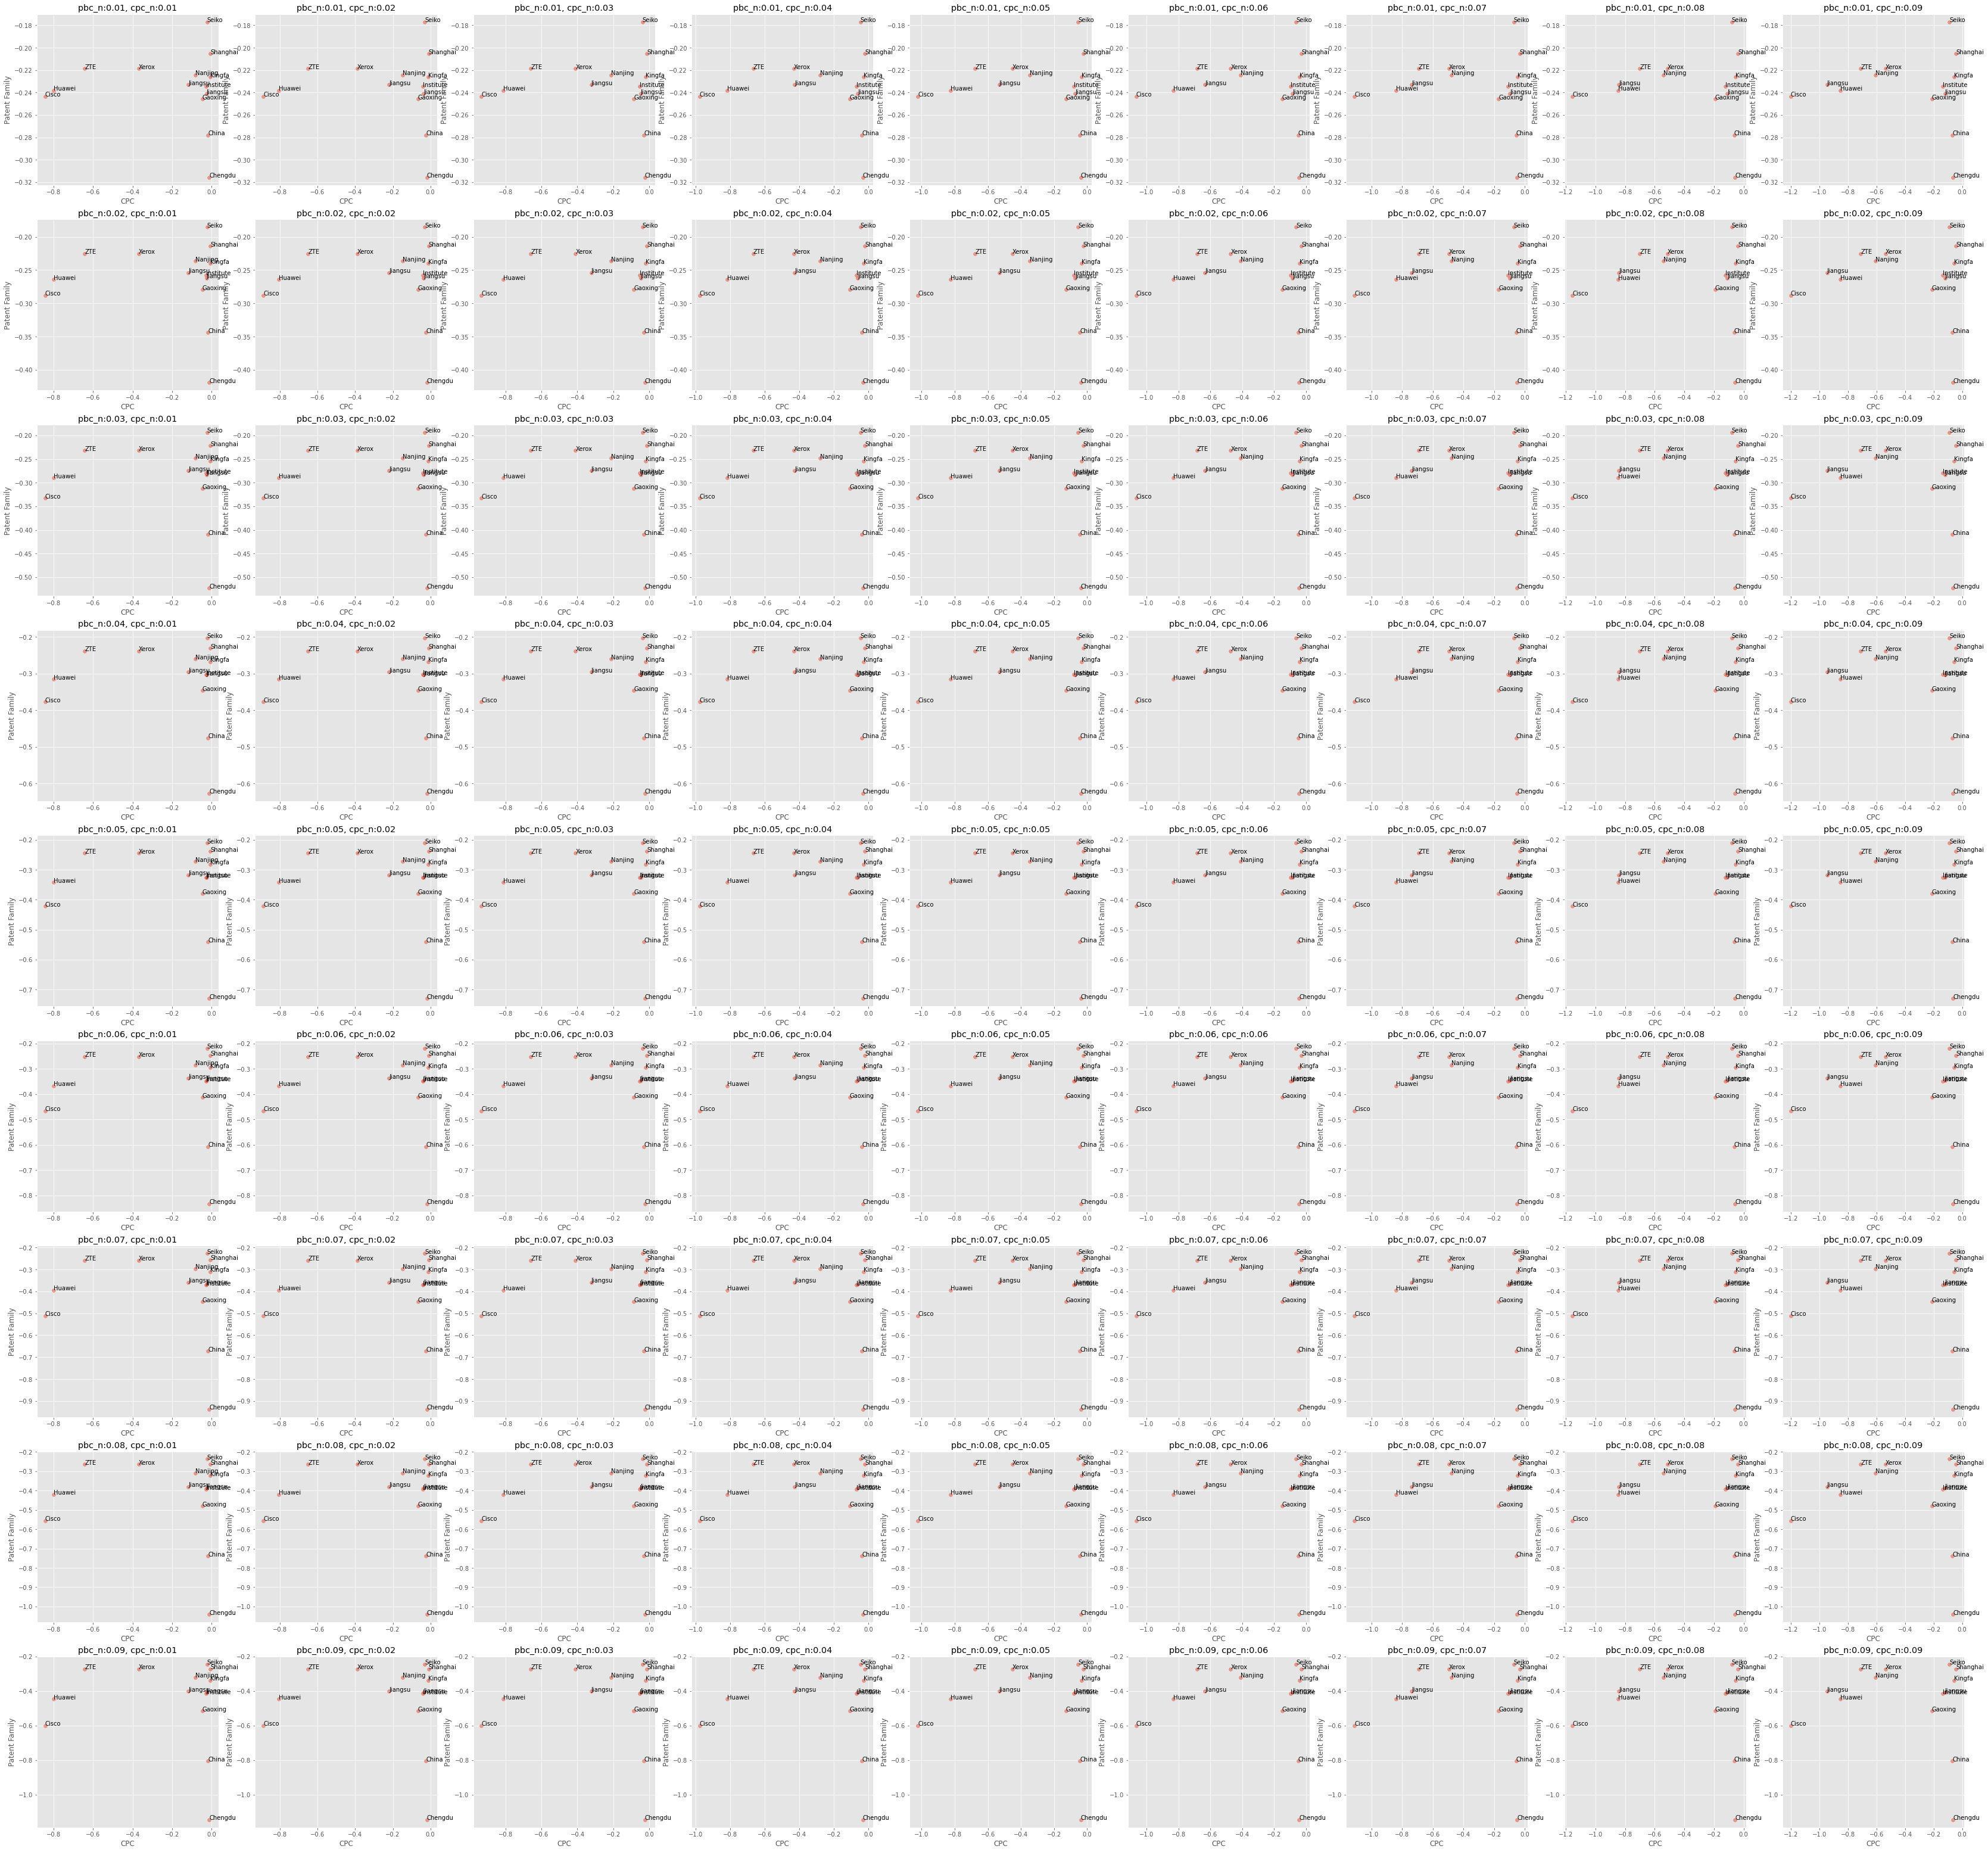

In [49]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2012_2.png'.format(pbc_n))

In [50]:
c_df

,cpc,country
company,,
Chengdu Qinchuan IoT Technology Co Ltd,0.064063,1.144626
China Petroleum and Chemical Corp,0.069638,0.804228
Cisco Technology Inc,1.199891,0.599668
"Gaoxing Zhilian Technology Co., Ltd.",0.212812,0.514373
Huawei Technologies Co Ltd,0.852055,0.445247
Institute of Microelectronics of CAS,0.137226,0.415724
Jiangsu CAS IGBT Technology Co Ltd,0.120821,0.408517
Jiangsu IoT Research and Development Center,0.945056,0.400543
Kingfa Science and Technology Co Ltd,0.059185,0.337152


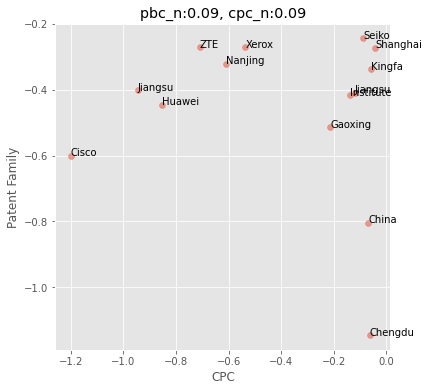

In [51]:
plt.figure(figsize=(6,6))
plt.style.use('ggplot')
c_df = scatter_plot(0.09,0.09)
c_df = c_df.drop("Samsung Electronics Co Ltd")

#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [52]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [53]:
competitor_ls

[3, 3, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2]

In [56]:
list(c_df.index)

['Chengdu Qinchuan IoT Technology Co Ltd',
 'China Petroleum and Chemical Corp',
 'Cisco Technology Inc',
 'Gaoxing Zhilian Technology Co., Ltd.',
 'Huawei Technologies Co Ltd',
 'Institute of Microelectronics of CAS',
 'Jiangsu CAS IGBT Technology Co Ltd',
 'Jiangsu IoT Research and Development Center',
 'Kingfa Science and Technology Co Ltd',
 'Nanjing IoT Sensor Technology Co Ltd',
 'Seiko Epson Corp',
 'Shanghai Kingfa Science and Technology Co Ltd',
 'Xerox Corp',
 'ZTE Corp']